# Multilayer Perceptron for Optical Character Recognition

Amitesh Sahu 21074006 

Rituraj Barai 21074024

Soustab Haldar 21074029


# Importing Libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from PIL import Image
from sklearn.model_selection import train_test_split

## Load data
One of the first steps when working with a new data set is preprocessing.  Our data here is from our dataset  of `28x28` black & white pixel images of handwritten preprocessed lowercase letters from `a-z`.
The dataset is in the form of folders for each of the alphabet where the folder name is the label for an image. For MLP, the image data has to be converted into numerical sing pillow library and python lists. Also, the array of image data should be appended with an appropriate label. The label alphabets are comverted into numerical values using a disctionary. Then the images are stored in the form of a list of image data lists.

In [2]:
root_dir=r"D:\IIT BHU\SEM V\IC\mlp-implementation\imgs\\"
dict = {chr(i): i - ord('a') + 1 for i in range(ord('a'), ord('z') + 1)}
lis = []
for i in os.listdir(root_dir):
    path=os.path.join(root_dir,i)
    for j in os.listdir(path):
        img_path=os.path.join(path,j)
        img = Image.open(img_path).convert('L')
        l=[dict[i]]
        li=list(img.getdata())
        l=l+li
        lis+=[l]
    print(i)

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


Then we write the image lists into a CSV file for easy access in further uses.

In [3]:
csv_dir=r"D:\IIT BHU\SEM V\IC\mlp-implementation\data\data.csv"
with open(csv_dir, 'w',newline='') as csvfile:   
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerows(lis) 

Loading the data from the CSV file and converting it into a list of image data lists and a list of labels as X and Y values for the MLP model respectively.

In [4]:
def load_data(dir_name):
    """
    Function for loading MNIST data stored in comma delimited files. Labels for 
    each image are the first entry in each row.

    Parameters
    ----------
    dit_name : str
         Path to where data is contained

    Returns
    -------
    X : array_like
        A (N x p=784) matrix of samples 
    Y : array_like
        A (N x 1) matrix of labels for each sample
    """
    data = list() # init a list called `data`
    
    with open(dir_name,"r") as f: # open the directory as a read ("r"), call it `f`
        for line in f: # iterate through each `line` in `f`
            split_line = np.array(line.split(',')) # split lines by `,` - cast the resultant list into an numpy array
            split_line = split_line.astype(np.float32) # make the numpy array of str into floats
            data.append(split_line) # collect the sample into the `data` list
            
    data = np.asarray(data) # convert the `data` list into a numpy array for easier indexing
    
    # as the first number in each sample is the label (0-9), extract that from the rest and return both (X,Y)
    return data[:,1:],data[:,0]

The data read from the CSV file has to be split into training and testing values. The training data is used to train the model and the testing data is used to test the model. The data is split into 80% training and 20% testing data. Using random state ensures that the splitting is completely random and does not follow any set pattern.

In [5]:
X_data,Y_data = load_data("data/data.csv")
X_train,X_test,Y_train,Y_test=train_test_split(X_data,Y_data,test_size=0.2,random_state=104)

Using the `.shape` attribute of numpy arrays. We see that the shape of `X_train` is `5933 x 784`, thus there are `5933` samples (images) each with dimension `784`. Each sample, typically presented as a 28 x 28 image, is unrolled into a 1-dimensional vector 28 x 28 = 784 contained within each row of `X_train`. Also shape of `X_train` is `1484 X 784`.

In [6]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 5933 x 784
The shape of the test set is: 1484 x 784


Viewing the data samples. We can see that `Y_train[index]` is `3.0` which means it represents the letter `c`. Subsequently the `X_train[index]` is the array of the values of all the pixels in that image between `0` and `255` brightness levels.

In [7]:
index = 0
Y_train[index], X_train[index]

(3.0,
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          1.,   1.,   1.,   1., 

Although the `0-255` representation is not inherently problematic, the choice of `255` as the maximum value is specific to image data and somewhat arbitrary for our purposes. It's common for individuals to transform their data to a `0-1` range, which offers certain mathematical advantages later on. This transformation can be easily achieved by dividing each entry in `X_train` and `X_test` by their respective maximum values, accessible through `X_train.max()`.

Additionally, the labels in `Y_train` and `Y_test` currently represent alphabets as integers (e.g., `25.0` or `2.0`). In the case of categorical data, where the labels correspond to values within the `0-26` range, a one-hot encoded representation is typically preferred.

In [8]:
# rescale data between 0 - 1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encode train (y_train) and test (y_test) set labels
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size),Y_train.astype(np.int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size),Y_test.astype(np.int)] = 1.0

C:\Users\Soustab\AppData\Local\Temp\ipykernel_10780\3197139449.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train[np.arange(Y_train.size),Y_train.astype(np.int)] = 1.0
C:\Users\Soustab\AppData\Local\Temp\ipykernel_10780\3197139449.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your curr

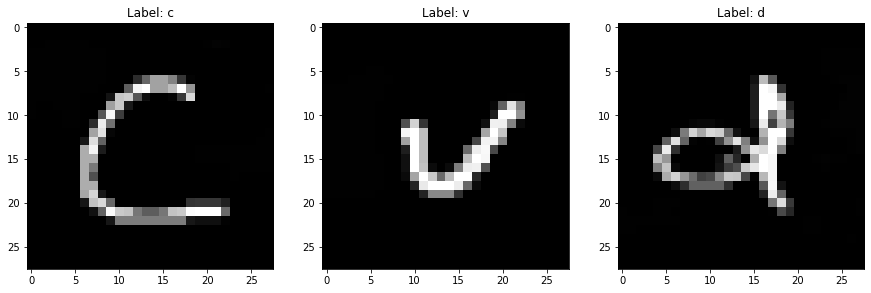

In [9]:
num_images = 3
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(X_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    for i in range(len(label)):
        if(label[i]==1.0):
            lab=list(dict.keys())[list(dict.values()).index(i)]
    ax.set_title(f"Label: {lab}")

# Multilayer Perceptron: 


Extending the perceptron to the multilayer perceptron (MLP) simply introduces a intermediate preceptrons (layers) before reading the output and generalizes the step function to a broader class of functions called *activation functions*. 

### Feed forward
Given a predefined neural network *architecture* (the *architecture* of a neural network refers to all the elements necessary to completely define the flow of data, which involve the number and size of hidden layers, which activation functions, the output size, etc.) the process of generating an output from an input is called a *forward* pass. As we shall see, for an MLP the forward pass may be succinctly represented as a series of matrix multiplications.

Consider the MLP represented schematically above with sigmoid activations $\sigma$ in the hidden layer. Each neuron in the hidden layers will be weighted sums of the inputs: $$a_j = \sigma(\sum_{i=1}^{784} x_i* w_{i,j})$$ for $j=\{1,2,\ldots,15\}$ 

The last step of process for classification tasks is actually producing a prediction from these numbers in the output layer $\mathbf{z}^{(2)}$. Typically, in the case of multi-label classification, this is done using a *softmax* activation function which effectively converts the output neurons into probabilities for each label. This has the mathematical form, $$\text{softmax}(\mathbf{z})_j = \frac{\exp(z_j)}{\sum_{k=0}^{K=9}\exp{(z_k)}}$$.



## Backpropagation

Initalizing all the weights, layers, and activations prior to the forward pass makes much of the backward pass implimentation actually quite simple.

We define a `sigmoid_prime` function, which simply computes the derivative of the sigmoid activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass. Recall, $\sigma^{\prime}(x) = \sigma(x)(1-\sigma(x))$.

We define the `tanh_prime` function, which simply computes the derivative of the tanh activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass. 

Recall,  $\sigma^{\prime}(x) = 1-\sigma(x)^2$.

## Training

The number of `epochs` we set defines the number of iterations we train our model. In each `epoch` a number of forward + backward pass are iteratively performed on mini-batches of data until our neural network has *seen* all the training data.


# Multilayer Perceptron: Code


In [18]:
class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(27)[Y.astype(np.int).reshape(-1)])
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(27)[Y_val.astype(np.int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))

    def __tanh(self,x):
        return np.tanh(x)
    
    def __softmax(self,x):
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __tanh_prime(self,h):
        return 1-h**2
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__tanh(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        # Update the weights of the network through back-propagation
        delta_t = (self.__out - batch_y)*self.__tanh_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__tanh_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")
    

MLP with only a single hidden layer `L=1` with 128 neurons `N_l=256`. We'll train with a `batch_size=50` for `epochs=100` and a learning rate `lr=0.8`.

In [19]:
model = MLP(X_train,Y_train,X_test,Y_test,L=1,N_l=256)
model.train(batch_size=8,epochs=100,lr=0.8)

C:\Users\Soustab\AppData\Local\Temp\ipykernel_10780\477408485.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.Y = np.squeeze(np.eye(27)[Y.astype(np.int).reshape(-1)])
C:\Users\Soustab\AppData\Local\Temp\ipykernel_10780\477408485.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

Epoch 1: loss = 2.979 | acc = 0.151 | val_loss = 2.67 | val_acc = 0.277 | train_time = 1.649 | tot_time = 1.664
Epoch 2: loss = 2.442 | acc = 0.394 | val_loss = 2.354 | val_acc = 0.433 | train_time = 1.648 | tot_time = 1.661
Epoch 3: loss = 2.255 | acc = 0.485 | val_loss = 2.299 | val_acc = 0.464 | train_time = 1.513 | tot_time = 1.527
Epoch 4: loss = 2.163 | acc = 0.536 | val_loss = 2.255 | val_acc = 0.449 | train_time = 1.604 | tot_time = 1.617
Epoch 5: loss = 2.098 | acc = 0.576 | val_loss = 2.173 | val_acc = 0.544 | train_time = 1.626 | tot_time = 1.64
Epoch 6: loss = 2.058 | acc = 0.601 | val_loss = 2.217 | val_acc = 0.498 | train_time = 1.692 | tot_time = 1.706
Epoch 7: loss = 2.029 | acc = 0.64 | val_loss = 2.151 | val_acc = 0.539 | train_time = 1.718 | tot_time = 1.733
Epoch 8: loss = 1.982 | acc = 0.663 | val_loss = 2.098 | val_acc = 0.606 | train_time = 1.688 | tot_time = 1.702
Epoch 9: loss = 1.953 | acc = 0.678 | val_loss = 2.145 | val_acc = 0.563 | train_time = 1.477 | tot

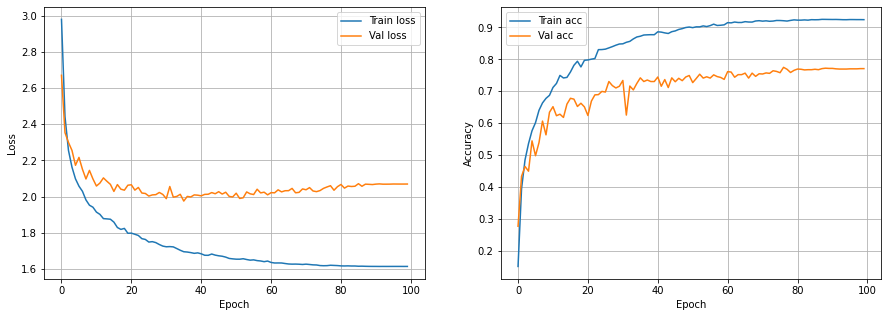

In [20]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

In [21]:
print("Accuracy: ",model.evaluate(X_test,y_test))

Accuracy:  0.77088948787062


### F1 Score, Recall, and Precision:

Precision is the ratio of true positives to the total number of predicted positives. It measures how many of the predicted positive cases are actually positive. A high precision score indicates that the model is good at predicting positive cases.

Recall is the ratio of true positives to the total number of actual positives. It measures how many of the actual positive cases are correctly predicted by the model. A high recall score indicates that the model is good at identifying positive cases.

F1 Score is the harmonic mean of precision and recall. It is a single score that balances both precision and recall. A high F1 score indicates that the model is good at both identifying positive cases and avoiding false positives.

In [22]:
from sklearn.metrics import precision_score,recall_score,f1_score
y_pred=model.predict(X_test)
y_pred=(np.argmax(y_pred, axis=1)+1).reshape(-1, 1).flatten()
y_test_c=(np.argmax(y_test, axis=1)+1).reshape(-1, 1).flatten()
# print(y_test_c)
print ('F1 score:', f1_score(y_test_c, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test_c, y_pred,average='weighted'))
print ('Precision:', precision_score(y_test_c, y_pred,average='weighted'))

F1 score: 0.7714634318296378
Recall: 0.77088948787062
Precision: 0.7761693053460852


C:\Users\Soustab\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
